In [1]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
#import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
#from apex import amp
import sys
import pickle
from skimage import exposure

In [2]:
train_orig = pd.read_pickle('lung_cancer_train.pkl')

In [3]:
train_generated = pd.read_pickle('df_gan_full.pkl')

In [4]:
train_orig 

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
703,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1015.0, -1024.0, -972.0, -975.0, -1013.0, -..."
704,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1022.0, -1024.0, -957.0, -987.0, -1022.0, -..."
705,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -951.0, -998.0, -1019.0, -..."
706,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1009.0, -968.0, -1022.0, -1007.0, ..."


In [5]:
train_generated = train_generated[:708]
train_generated

,ct_image,cancer_mask
0,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
1,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
2,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
3,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
4,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
...,...,...
703,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
704,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
705,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
706,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."


In [6]:
import pandas as pd

# Merge 'hu_array_old' from train_orig with 'ct_image' from train_generated
hu_array_ct_image_df = pd.concat([train_orig['hu_array_old'], train_generated['ct_image']], axis=0)

# Reset the index to make it continuous
hu_array_ct_image_df = hu_array_ct_image_df.reset_index(drop=True)

# Merge 'mask' from train_orig with 'cancer_mask' from train_generated
mask_cancer_mask_df = pd.concat([train_orig['mask'], train_generated['cancer_mask']], axis=0)

# Reset the index to make it continuous
mask_cancer_mask_df = mask_cancer_mask_df.reset_index(drop=True)

# Concatenate hu_array_ct_image_df and mask_cancer_mask_df along the columns axis
train_df = pd.concat([hu_array_ct_image_df, mask_cancer_mask_df], axis=1)
# Rename the columns in train_df
train_df = train_df.rename(columns={0: 'hu_array', 1: 'mask'})


In [7]:
train_df

,hu_array,mask
0,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
1411,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
1412,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
1413,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."
1414,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...","[[False, False, False, False, False, False, Fa..."


In [8]:
val_df = pd.read_pickle('lung_cancer_test.pkl') 

In [9]:
val_df

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
259,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
260,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
261,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
262,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."


In [10]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    #pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    #dim = ct_img.header["dim"] # example [1,512,512,1,1]
    #max_indx = np.argmax(dim)
    #pixdimX = pix_dim[max_indx]
    #dim = np.delete(dim, max_indx)
    #pix_dim = np.delete(pix_dim, max_indx)
    #max_indy = np.argmax(dim)
    #pixdimY = pix_dim[max_indy]
    return [1, 1]
def make_dirs(path):
    """
    Creates the directory as specified from the path
    in case it exists it deletes it
    """
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area

    """
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours


#def show_contour(image, contours, name=None, save=False):
#    fig, ax = plt.subplots()
    #ax.imshow(image.T, cmap=plt.cm.gray)
    #for contour in contours:
    #    ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    #ax.set_xticks([])
    #ax.set_yticks([])

    #if save:
    #    plt.savefig(name)
    #    plt.close(fig)
    #else:
    #    plt.show()



def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

def save_nifty(img_np, name, affine):
    """
    binary masks should be converted to 255 so it can be displayed in a nii viewer
    we pass the affine of the initial image to make sure it exits in the same
    image coordinate space
    Args:
        img_np: the binary mask
        name: output name
        affine: 4x4 np array
    Returns:
    """
    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')


def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that get the pixdim indicated from the image
    dimensions. From the last 2 image dimensions we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    #pix_dim = [1,1]
    #dim = ct_img.header["dim"]
    #max_indx = np.argmax(dim)
    #pixdimX = pix_dim[max_indx]
    #dim = np.delete(dim, max_indx)
    #pix_dim = np.delete(pix_dim, max_indx)
    #max_indy = np.argmax(dim)
    #pixdimY = pix_dim[max_indy]
    return [1,1]

def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

In [11]:
train_df['hu_array_old'] = train_df['hu_array']

In [12]:
from scipy.spatial import ConvexHull
from skimage import measure
from PIL import Image, ImageDraw
import copy
import random
import copy
from scipy import ndimage

In [13]:
def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    return vessels 


In [ ]:
a = []
for i in (train_df.index):
    contour_name = 'test'
    out_mask_name = 'test1'
    ct_numpy = train_df['hu_array'][i]
    try:
        contours = intensity_seg(ct_numpy, min=-1000, max=-300)
        lungs = find_lungs(contours)
        #show_contour(ct_numpy, lungs, contour_name,save=True)
        lung_mask = create_mask_from_polygon(ct_numpy, lungs)
        #vessels = create_vessel_mask(lung_mask, ct_numpy)
        a.append(lung_mask * ct_numpy)
    except: 
        a.append(ct_numpy)
    #a.append(vessels * train_csv['hu_array'][i])
train_df['hu_array'] = a

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet(
    encoder_name="vgg11",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).cuda()

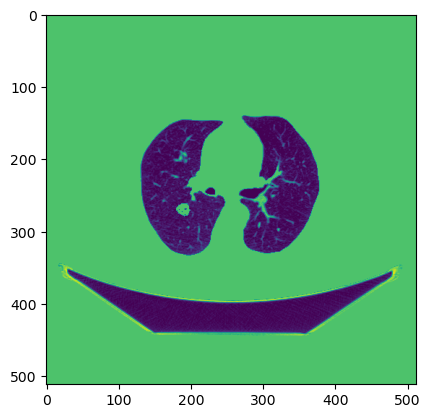

In [17]:
plt.imshow(train_df['hu_array'][1200])

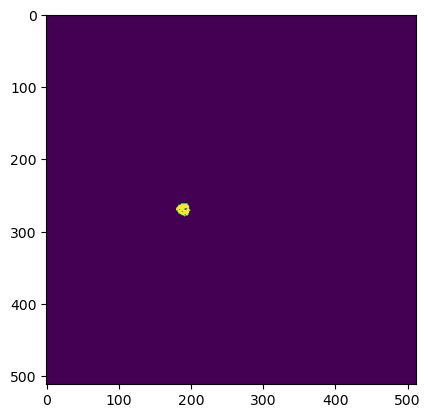

In [18]:
plt.imshow(train_df['mask'][1200])

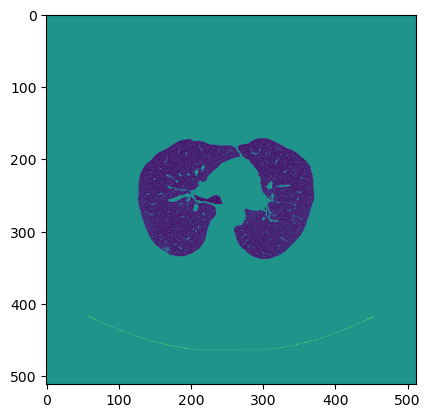

In [19]:
plt.imshow(train_df['hu_array'][50])

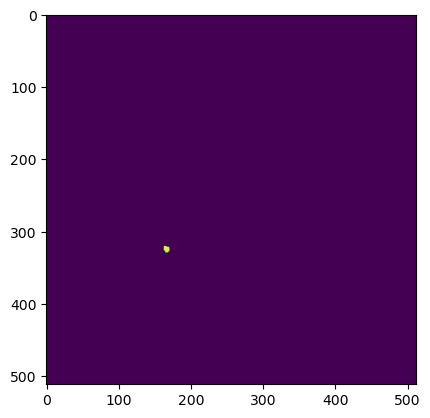

In [20]:
plt.imshow(train_df['mask'][50])

In [21]:
print(sum(p.numel() for p in model.parameters()))

18252881


In [22]:
from torch.utils.data import Dataset
from skimage.transform import resize
class MyDataset(Dataset):
    def __init__(self, dataframe, transforms):
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.df.hu_array.values[idx]     
        img = (img-np.min(img))/(np.max(img)-np.min(img))
        img = exposure.equalize_adapthist(img/np.max(img))
        #img = np.stack((img, img, img), axis=2)
        img = img.astype(np.float64)
        mask = self.df['mask'].values[idx]   
        mask = mask ** 2
        masks = (mask > 0.5).astype(int)
        if self.transforms:
            img, masks = self.transforms(img, masks)
        return img, masks

    def __len__(self):
        return len(self.df)

In [23]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [24]:
import utils
trainset      = MyDataset(train_df, get_transform(True))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=6)
valset       = MyDataset(val_df,get_transform(True))
val_loader   = torch.utils.data.DataLoader(valset, batch_size=6)

In [25]:
import tqdm
for img,target in tqdm.tqdm(train_loader):
    z = 1

100%|██████████| 236/236 [01:17<00:00,  3.04it/s]


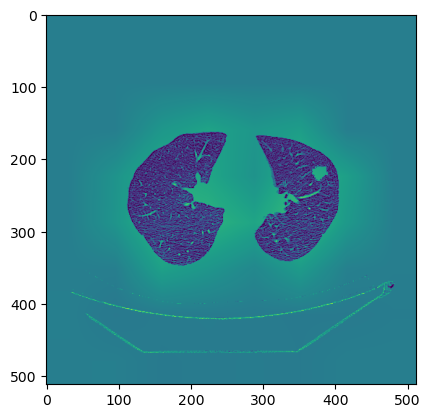

In [26]:
plt.imshow(img[2][0].cpu().detach().numpy())

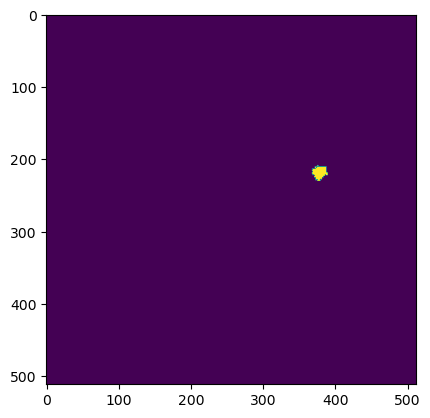

In [27]:
plt.imshow(target[2].cpu().detach().numpy())

In [28]:

model

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel

In [29]:
import torch.optim as optim
class DiceLossNew(nn.Module):
    def __init__(self):
        super(DiceLossNew, self).__init__()

    def forward(self, prediction, target):
        smooth = 0.0000000001  

        intersection = (prediction * target).sum()
        union = prediction.sum() + target.sum() + smooth

        dice_coefficient = (2. * intersection + smooth) / union
        dice_loss = 1 - dice_coefficient

        return dice_loss

In [30]:
def dice_loss(pred, target):
    pred = torch.sigmoid(pred)

    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = torch.sum(pred * target)
    pred_sum = torch.sum(pred * pred)
    target_sum = torch.sum(target * target)

    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))

In [31]:
criterion = dice_loss
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [33]:
losses = []
vlosses = []

In [34]:
iter_num = 0
n_epoch = 40
start_time = time.time()

for epoch_num in range(n_epoch):
    loss_ = []
    vloss_ = []
    for i_batch, sampled_batch in enumerate(train_loader):
        image_batch, label_batch = sampled_batch
        #image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        image_batch = image_batch.float()
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        #outputs = net(torch.FloatTensor(image_batch))
        outputs = model(image_batch)
        outputs = torch.squeeze(outputs, 1)
        loss = criterion(outputs, label_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_,axis = 0))
    print('train epoch ',epoch_num)
    print('-------- train dice ce total', np.mean(loss_,axis = 0))
    with torch.no_grad():
        for i_batch, sampled_batch1 in enumerate(val_loader):
            image_batch1, label_batch1 = sampled_batch1
            image_batch1 = image_batch1.float()
            image_batch1, label_batch1 = image_batch1.cuda(), label_batch1.cuda()
            outputs1 = model(image_batch1)
            outputs1 = torch.squeeze(outputs1, 1)
            vloss = criterion(outputs1, label_batch1.float())
            vloss_.append(vloss.item())
        vlosses.append(np.mean(vloss_,axis = 0))
        print('-------- test loss ', np.mean(vloss_,axis = 0))
end_time = time.time()

train epoch  0
-------- train dice ce total 0.9929295108985092
-------- test loss  0.9922133480960672
train epoch  1
-------- train dice ce total 0.8895287155094793
-------- test loss  0.9992769780484113
train epoch  2
-------- train dice ce total 0.5976100596836058
-------- test loss  0.8263216736641797
train epoch  3
-------- train dice ce total 0.42713680484537353
-------- test loss  0.6707774034955285
train epoch  4
-------- train dice ce total 0.4021786905951419
-------- test loss  0.727840321985158
train epoch  5
-------- train dice ce total 0.31533651028649284
-------- test loss  0.6587765392932025
train epoch  6
-------- train dice ce total 0.27531355720455364
-------- test loss  0.6360474757172845
train epoch  7
-------- train dice ce total 0.2440432229284513
-------- test loss  0.5674185048450123
train epoch  8
-------- train dice ce total 0.25150313821889586
-------- test loss  0.6037079095840454
train epoch  9
-------- train dice ce total 0.23958003091610083
-------- test l

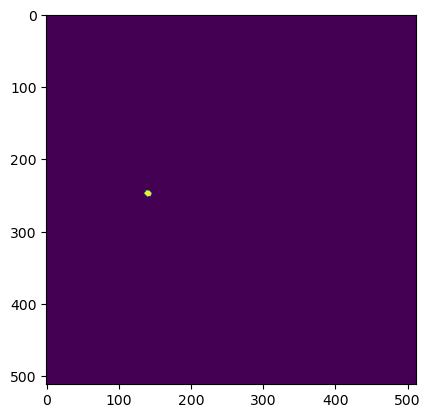

In [35]:
plt.imshow(label_batch[0].cpu().detach().numpy())

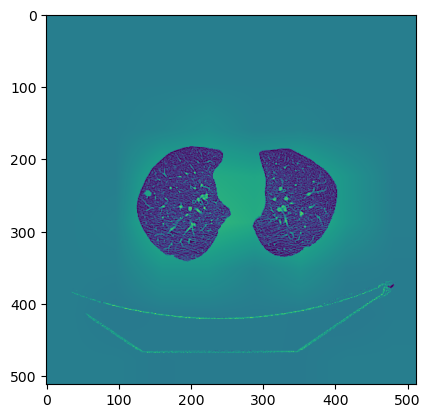

In [36]:
plt.imshow(image_batch[0][0].cpu().detach().numpy())

In [37]:
def dice_coeff(pred, target):
    m1 = np.array(pred).flatten()
    m2 = np.array(target).flatten()
    intersection = np.sum(m1 * m2)
    if (m1.sum() + m2.sum()) == 0: 
        return 0 
    else: 
        return (2. * intersection ) / (m1.sum() + m2.sum() )

In [38]:
model.eval()

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel

In [39]:
d = []
labels = val_df['label1'].unique()
for j in labels:
    dices = []
    test = val_df.loc[val_df['label1'] == j].reset_index(drop=True)
    for i in range(len(test)):
        img = test['hu_array'][i]
        img = (img-np.min(img))/(np.max(img)-np.min(img))
        img = exposure.equalize_adapthist(img/np.max(img))
        img = img.astype(np.float64)
        mask = (test['mask'][i] > 0)**2
        mask = np.array(mask)
        masks = mask.astype(int)
        img = img.astype(np.float64)
        img = transforms.ToTensor()(img)
        img = torch.unsqueeze(img, 0)
        img = img.float()
        img = img.cuda()
        masks = mask.astype(int)
        outputs = model(img)
        outputs = torch.sigmoid(outputs)
        try:
            mask_pred = (outputs.cpu().detach().numpy() >= 0.5) ** 2
        except:
            mask_pred = np.zeros([512,512])
        dices.append(dice_coeff(masks, mask_pred))
        d.append(dice_coeff(masks, mask_pred))
    print("Dice for " + j + " " + str(np.mean(dices))+" " +str(len(dices)))
    #plt.imshow(out[0]['masks'][0].cpu().detach().numpy()[0])
np.mean(d)

Dice for LR2 0.07938721903826598 35
Dice for LR3 0.31763971672523983 37
Dice for LR4A 0.3382312943456157 97
Dice for LR4B 0.613634722497874 95


0.40013241050756043

In [40]:
torch.save(model.state_dict(), 'U-Net with VGG/u-net_GAN_aug.pth')